# Initializing and read files to numpy arrays

In [3]:
# %matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler

import uproot ## means uproot4
import sklearn.metrics as m


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

mass_min, mass_max, pt_min, pt_max, abs_eta_max= 60, 150, 200, 800, 2.4

filedict={
    'latest': [
        '/home/olympus/fudawei/tagger/XWW/prediction/ak8.MD.sdmass.5PIDvar/GluGlutoHH4W_MH125.root',
        '/home/olympus/fudawei/tagger/XWW/prediction/ak8.MD.sdmass.5PIDvar/QCD.root',
        '/home/olympus/fudawei/tagger/XWW/prediction/ak8.MD.sdmass.5PIDvar/Top.root',
        '/home/olympus/fudawei/tagger/XWW/prediction/ak8.MD.sdmass.5PIDvar/W_jets.root',
    ],
    #'mW=80': [
    #    '/home/olympus/fudawei/weaver/predict/HWWvsQCD/pnet.HWWvsQCD.sdmass.5PIDvar/HHWW_M1000_new.root',
    #    '/home/olympus/fudawei/weaver/predict/HWWvsQCD/pnet.HWWvsQCD.sdmass.5PIDvar/QCD_allPt_WW_new.root',
    #],
    'previous': [
        '/home/olympus/licq/hww/fdw-weaver/predict/HWWvsQCD/pnet.HWWvsQCD.sdmass.5PIDvar.variableWMass.sigx2//HHWW_M1000_new.root',
        '/home/olympus/licq/hww/fdw-weaver/predict/HWWvsQCD/pnet.HWWvsQCD.sdmass.5PIDvar.variableWMass.sigx2//QCD_allPt_WW_new.root',
    ],
    #'nonMD': [
    #    '/home/olympus/fudawei/weaver/predict/HWWvsQCD/pnet.HWWvsQCD.nonMD/HHWW_M1000_new.root',
    #    '/home/olympus/fudawei/weaver/predict/HWWvsQCD/pnet.HWWvsQCD.nonMD/QCD_allPt_WW_new.root'
    #]
}

events, labels, variables = {tagger: {} for tagger in filedict}, {tagger: set() for tagger in filedict}, {tagger: set() for tagger in filedict}
for tagger in events:
    ## optional opening methods: uproot.lazy({ "$FILEPATH": "TTree", ...}) or uproot.lazy(["$FILEPATH:TTree", ...])
    ak_arrays = uproot.lazy({file: 'Events' for file in filedict[tagger]}) ## lazy means lazy computation style
    for var in ak_arrays.fields:
        if 'label_' in var:
            if tagger != 'new' and 'W_' in var:
                continue
            labels[tagger].add(var.replace('score_', '').replace('label_', '')) 
        else:
            variables[tagger].add(var)
        events[tagger][var.replace('label_', '')] = ak_arrays[var].to_numpy()
        


___
# Start analyzing

### first look into properties

In [4]:
for tagger in events:
    print(f'Samples inferred by {tagger} tagger:')
    print('\tlabels:',labels[tagger])
print()
print('Common variables:',variables[tagger])

Samples inferred by latest tagger:
	labels: {'QCD_c', 'Top_bWqq', 'Wqq_jets', 'QCD_b', 'Top_bWmv', 'Top_bWtauev', 'QCD_others', 'Top_bWtauhv', 'QCD_bb', 'Top_bWtaumv', 'H_WqqWtauhv', 'H_WqqWtauev', 'Top_bWev', 'H_WqqWq', 'H_WqqWqq', 'H_WqqWmv', 'QCD_cc', 'Top_bWq', 'H_WqqWtaumv', 'H_WqqWev'}
Samples inferred by previous tagger:
	labels: {'H_wwleptauevqq', 'QCD_c', 'H_wwhadtauvqq', 'QCD_others', 'H_ww3q', 'H_wwmvqq', 'H_wwleptaumvqq', 'QCD_bb', 'H_ww4q', 'H_wwevqq', 'QCD_b', 'QCD_cc'}

Common variables: {'pfParticleNetDiscriminatorsJetTags_WvsQCD', 'pfMassDecorrelatedParticleNetDiscriminatorsJetTags_XbbvsQCD', 'fj_sdmass', 'sample_isQCD', 'pfDeepBoostedDiscriminatorsJetTags_WvsQCD', 'fj_label', 'pfMassDecorrelatedDeepBoostedDiscriminatorsJetTags_ZHbbvsQCD', 'pfDeepBoostedDiscriminatorsJetTags_TvsQCD', 'pfMassDecorrelatedDeepBoostedDiscriminatorsJetTags_TvsQCD', 'pfParticleNetDiscriminatorsJetTags_HbbvsQCD', 'fj_isQCD', 'fj_genjet_sdmass', 'fj_eta', 'pfMassDecorrelatedParticleNetJetTags_

### sum over labels and scores

In [5]:
def mergeClass(tagger, old, new):
    if old not in events[tagger]:
        return
    events[tagger][new] = events[tagger].get(new, np.zeros_like(events[tagger][old])) + events[tagger][old]
    if 'score_'+old not in events[tagger]:
        return
    events[tagger]['score_'+new] = events[tagger].get('score_'+new, np.zeros_like(events[tagger]['score_'+old])) + events[tagger]['score_'+old]    

for tagger in events:
    for l in list(labels[tagger]):
        if l.startswith('QCD_'):
            mergeClass(tagger, old=l, new='QCD')
            mergeClass(tagger, old=l, new='BKG')
            labels[tagger].add('QCD')
            labels[tagger].add('BKG')
            labels[tagger].remove(l)
        elif l.startswith('Top_'):
            mergeClass(tagger, old=l, new='Top')
            mergeClass(tagger, old=l, new='BKG')
            labels[tagger].add('Top')
            labels[tagger].add('BKG')
            labels[tagger].remove(l)
        elif l.startswith('H_ww4q') or l.startswith('H_ww3q') or l.startswith('H_qqqq') or l.startswith('H_WqqWq'):
            mergeClass(tagger, old=l, new='H_WqqWhad')
            labels[tagger].add('H_WqqWhad')
            labels[tagger].remove(l)
        elif l.startswith('H_wwevqq') or l.startswith('H_wwmvqq') or l.startswith('H_wwleptauevqq') or l.startswith('H_wwleptaumvqq') or l.startswith('H_wwhadtauvqq') or l.startswith('H_WqqWtau') or l.startswith('H_WqqWev') or l.startswith('H_WqqWmv'):
            mergeClass(tagger, old=l, new='H_WqqWlep')
            labels[tagger].add('H_WqqWlep')
            labels[tagger].remove(l)
        elif l.startswith('Wqq_jets'):
            mergeClass(tagger, old=l, new='W+jets')
            mergeClass(tagger, old=l, new='BKG')
            labels[tagger].add('BKG')
            labels[tagger].add('W+jets')
            labels[tagger].remove(l)



In [6]:
labels

{'latest': {'BKG', 'H_WqqWhad', 'H_WqqWlep', 'QCD', 'Top', 'W+jets'},
 'previous': {'BKG', 'H_WqqWhad', 'H_WqqWlep', 'QCD'}}

### define cuts

In [7]:
pt_cut = {tagger: (events[tagger]['fj_pt']>pt_min)&(events[tagger]['fj_pt']<pt_max) for tagger in events}
eta_cut = {tagger: np.abs(events[tagger]['fj_eta'])<abs_eta_max for tagger in events}
mass_cut = {tagger: (events[tagger]['fj_sdmass']>mass_min)&(events[tagger]['fj_sdmass']<mass_max) for tagger in events}
full_cut = {tagger: pt_cut[tagger]&eta_cut[tagger]&mass_cut[tagger] for tagger in events}
no_mass_cut = {tagger: pt_cut[tagger]&eta_cut[tagger] for tagger in events}

### use cuts

In [8]:
cut_events = {
    tagger: {
        var: events[tagger][var][full_cut[tagger]] for var in events[tagger]
    } for tagger in events
}

no_m_cut_events = {
    tagger: {
        var: events[tagger][var][no_mass_cut[tagger]] for var in events[tagger]
    } for tagger in events
}

In [9]:
cut_events['latest']['score_H_WqqWev'][cut_events['latest']['H_WqqWev']==1]

array([0.8559631 , 0.22094692, 0.88747144, ..., 0.3970556 , 0.57309586,
       0.84866524], dtype=float32)

In [10]:
cut_events['previous']['score_H_wwevqq'][cut_events['previous']['H_wwevqq']==1]

array([0.77232295, 0.01606259, 0.93949026, ..., 0.92565715, 0.69638896,
       0.92155373], dtype=float32)

### How to calculate discriminant score

In [11]:
def disc_score(event, sig, bkg):
    return event['score_'+sig]/(event['score_'+sig]+event['score_'+bkg])

### plot discriminant scores

In [12]:
def plot_discriminant_score(events, x_score, y_score, bins=50, x_min=0, x_max=1, legend_location='best'):
    x_label, y_label = x_score.replace('score_', ''), y_score.replace('score_', '')
    plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')


    for tagger, e in events.items():
        disc_score_tagger=disc_score(e, sig=x_label, bkg=y_label)
        true_x = disc_score_tagger[e[x_label]==1]
        true_y = disc_score_tagger[e[y_label]==1]
        
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(true_x)
        h, err = hist.view().value, np.sqrt(hist.view().variance)
        hep.histplot(h/(sum(h)+1e-10), bins=hist.axes[0].edges, yerr=err/(sum(h)+1e-10), linestyle='solid', label=tagger+': '+x_label, histtype='step',ax=ax)
        
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(true_y)
        h, err = hist.view().value, np.sqrt(hist.view().variance)
        hep.histplot(h/(sum(h)+1e-10), bins=hist.axes[0].edges, yerr=err/(sum(h)+1e-10), linestyle='solid', label=tagger+': '+y_label, histtype='step',ax=ax)
    
    plt.xlim(0, 1)
    plt.ylim(0, ax.get_ylim()[1]*1.3)
    #x_major_locator=plt.MultipleLocator(0.1)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel(f'score: {x_label}/({x_label}+{y_label})', fontsize=20, ha='right', x=1)
    plt.ylabel(r'A.U.', fontsize=20, ha='right', y=1)
    #plt.xscale('log')
    plt.xticks(size=14)
    plt.yticks(size=14)

    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc=legend_location,frameon=False,fontsize=18)

    
    plt.savefig(f"plots/{x_score}_vs_{y_score}.pdf", bbox_inches='tight')
    plt.show()

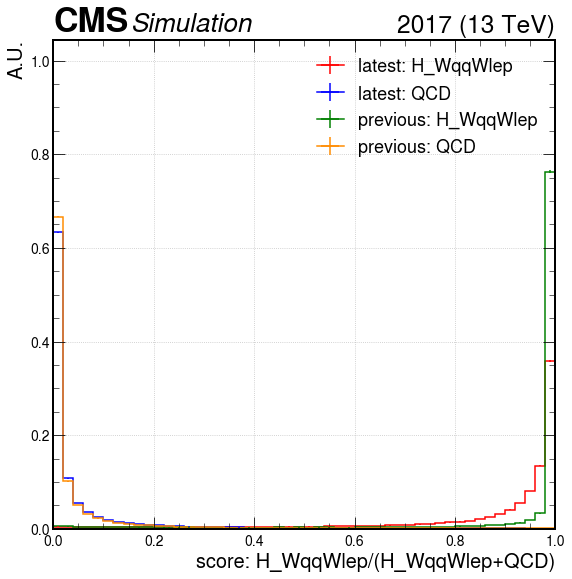

In [13]:
plot_discriminant_score(events=cut_events, x_score='score_H_WqqWlep', y_score='score_QCD')

### plot ROC and AUC

In [14]:
def plot_ROC(events, x_label, y_label, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')
    plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','darkviolet'])
    
    plt.plot([plt.xlim()[0],plt.xlim()[1]], [0.01,0.01], linestyle="dashed", lw=2, color='gray')    
    for tagger, e in events.items():
        if x_label not in e:
            continue
        if x_label not in labels[tagger] or y_label not in labels[tagger]:
            continue
        x_y_truth = (e[x_label]==1) | (e[y_label]==1)
        _disc_score = disc_score(e, sig=x_label, bkg=y_label)[x_y_truth]
        fpr, tpr, _threshold = roc_curve(y_true=e[x_label][x_y_truth], y_score=_disc_score, pos_label=1)
        plt.plot(tpr, fpr, linestyle="solid", lw=2, label=tagger) #+', AUC=%.2f%%'%(roc_auc[tagger][channel]*100))
        index=np.where(fpr==min(fpr, key=lambda x:abs(x-0.01), ))[0]
        plt.plot([tpr[index], tpr[index]], [plt.ylim()[0], 0.01], linestyle="dashed", lw=2, color='gray')
        
    plt.xlim(0, 1)
    plt.ylim(1e-4,1)
    x_major_locator=plt.MultipleLocator(0.1)
    #y_major_locator=MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel(f'{x_label} efficiency', fontsize=24, ha='right', x=1)
    plt.ylabel(f'Mistag rate ({y_label})', fontsize=24, ha='right', y=1)
    plt.yscale('log')
    plt.xticks(size=14)
    plt.yticks(size=14)

    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc=legend_location,frameon=False,fontsize=20)
    plt.text(0.03, 0.4e-0, x_label + " vs. "+y_label, fontsize=26, color="black")
    plt.text(0.03, 0.2e-0, rf"$\rm {pt_min}GeV<p_T<{pt_max}GeV,\ |\eta|<{abs_eta_max},\ \rm {mass_min}GeV<m_{{SD}}<{mass_max}GeV$", fontsize=16,color="black")
    #plt.text(0.1, 0.9e-1,r"$\rm 90GeV<m_{SD}<140GeV$", fontsize=16,color="black")
    #plt.text(0.1, 0.2e-1,"AUC(MD)=%.4f"%(roc_auc_new), fontsize=20,color="red")
    #plt.text(0.5, 0.2e-3,"AUC(non-MD)=%.4f"%(roc_auc_old), fontsize=20,color='blue')

    
    plt.savefig(f"plots/ROC_{y_label}_{x_label}.pdf", bbox_inches='tight')
    plt.show()

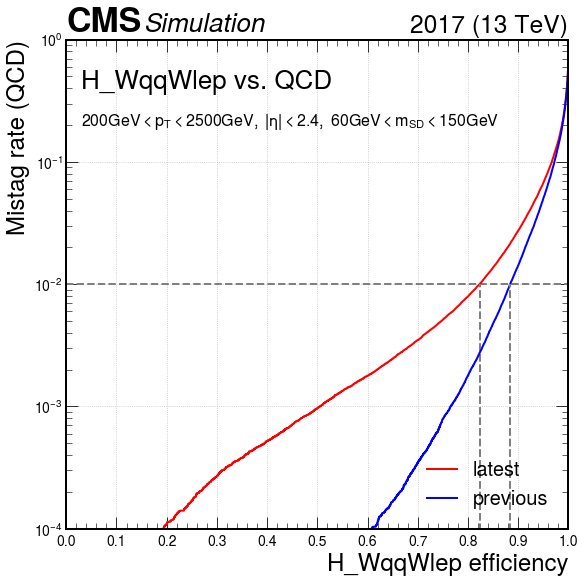

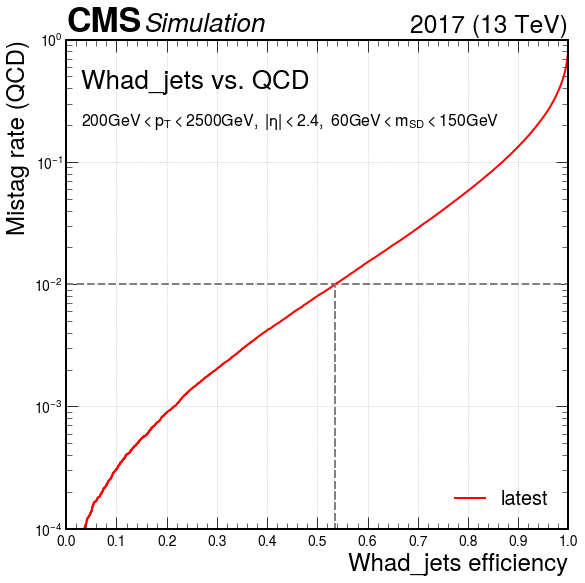

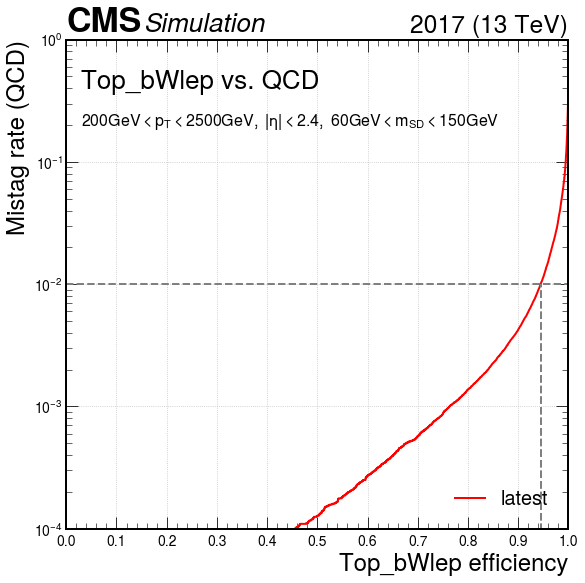

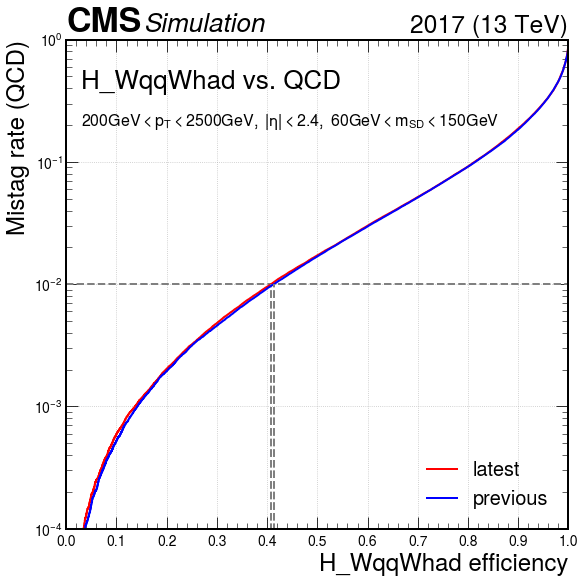

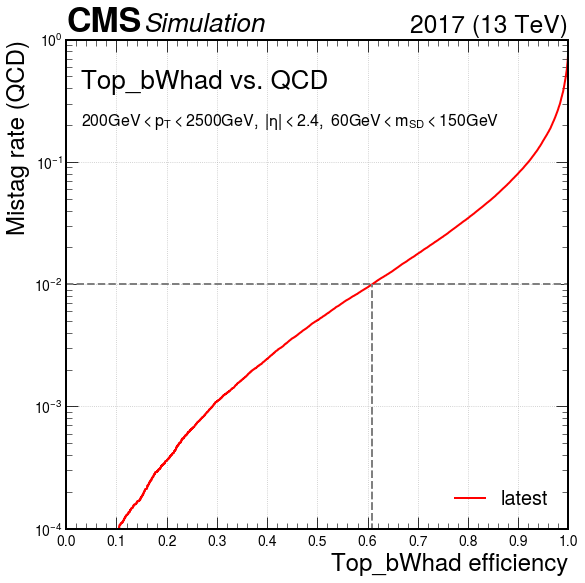

In [134]:
for xlabel in ['H_WqqWhad', 'H_WqqWlep']:
    for ylabel in ['QCD', 'Top', 'W+jets', 'BKG']:
        plot_ROC(events=cut_events, x_label=xlabel, y_label=ylabel, legend_location='lower right')

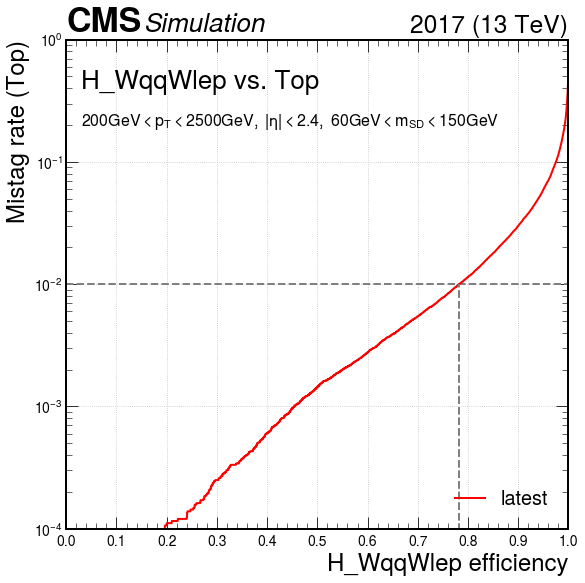

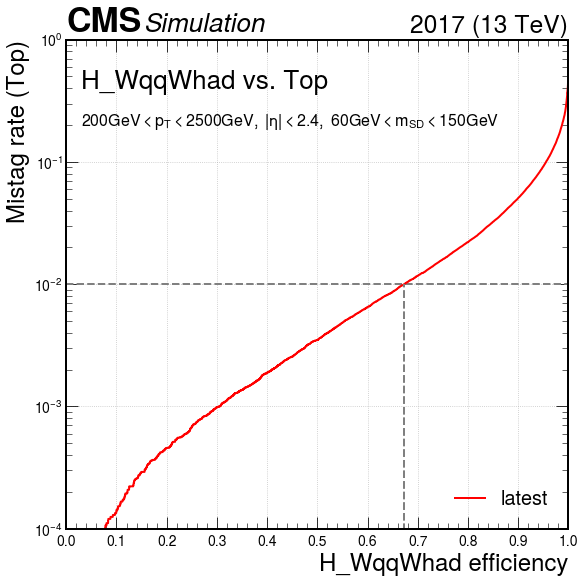

In [147]:
for xlabel in ['H_WqqWlep', 'H_WqqWhad']:
    plot_ROC(events=cut_events, x_label=xlabel, y_label='Top', legend_location='lower right')

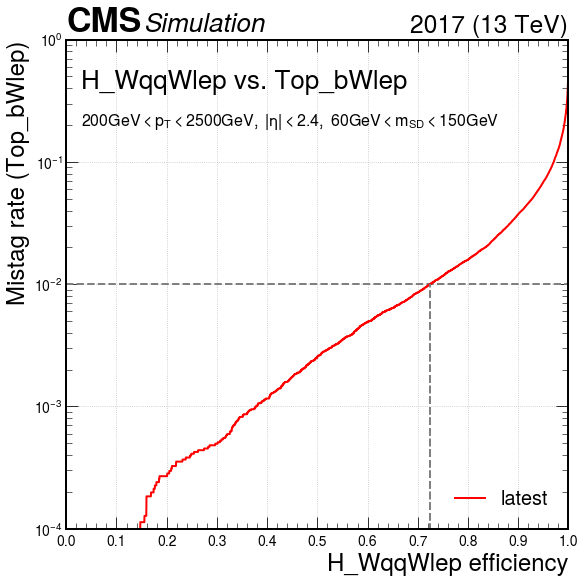

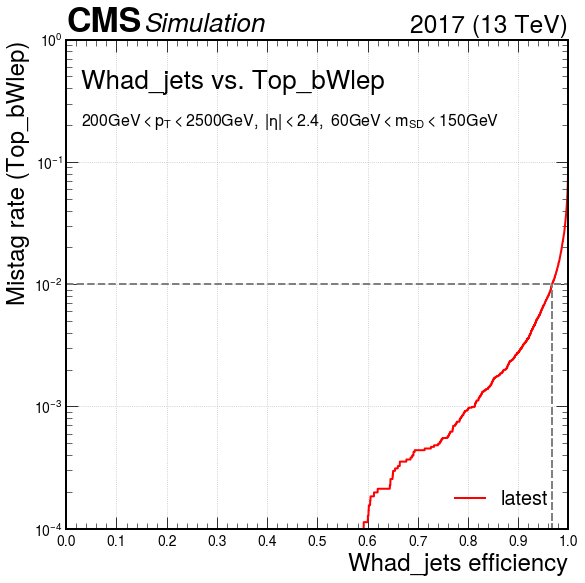

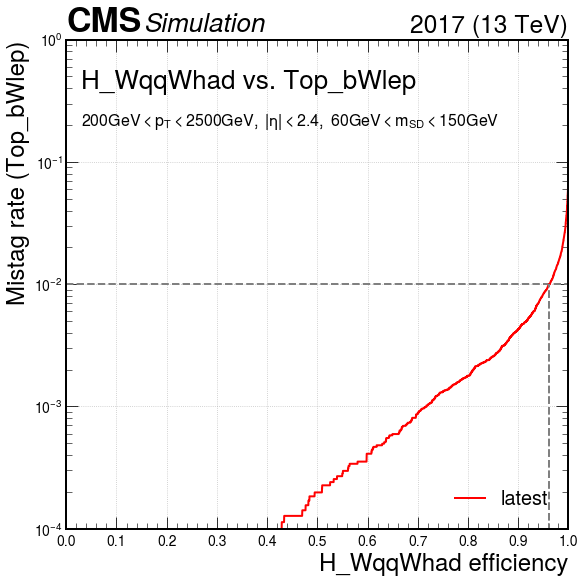

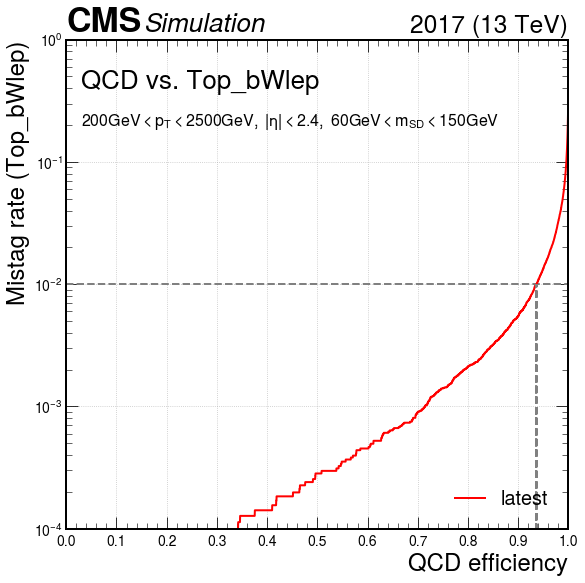

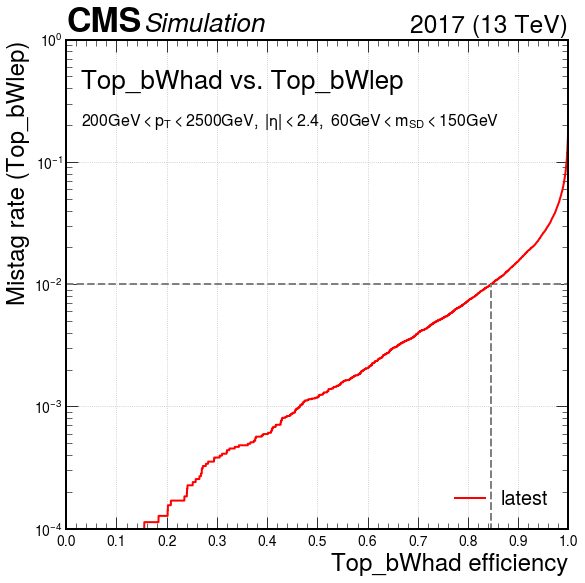

In [135]:
for xlabel in labels['latest']:
    plot_ROC(events=cut_events, x_label=xlabel, y_label='Top_bWlep', legend_location='lower right')

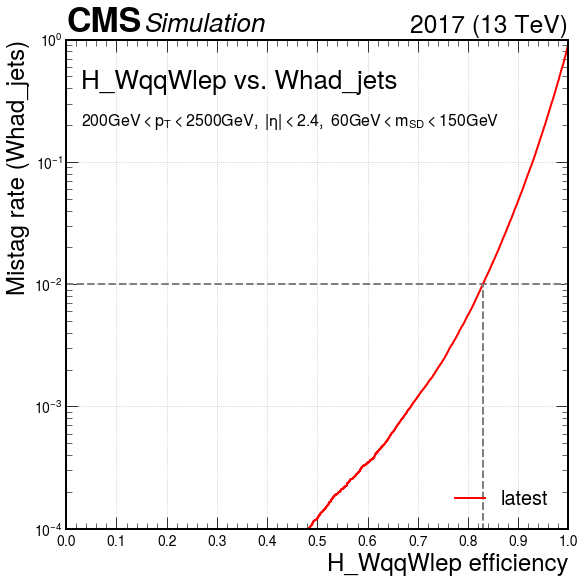

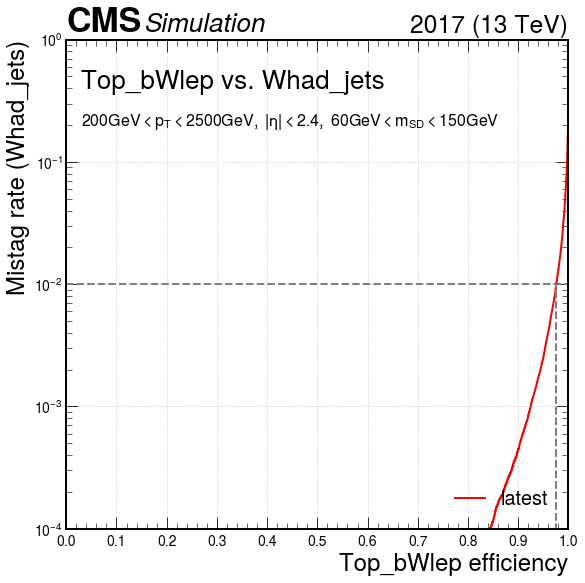

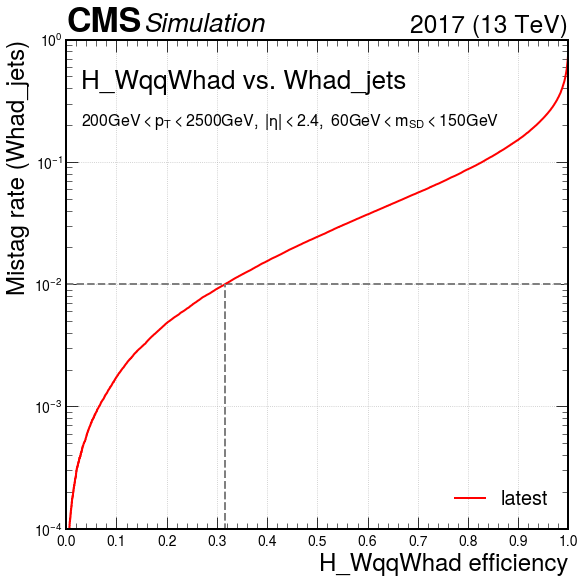

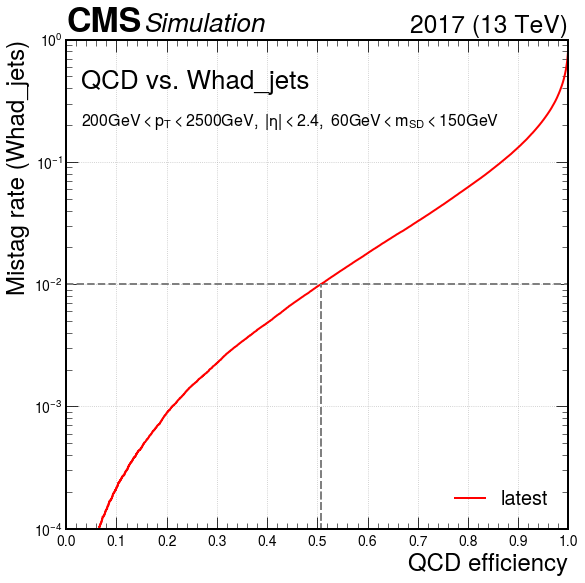

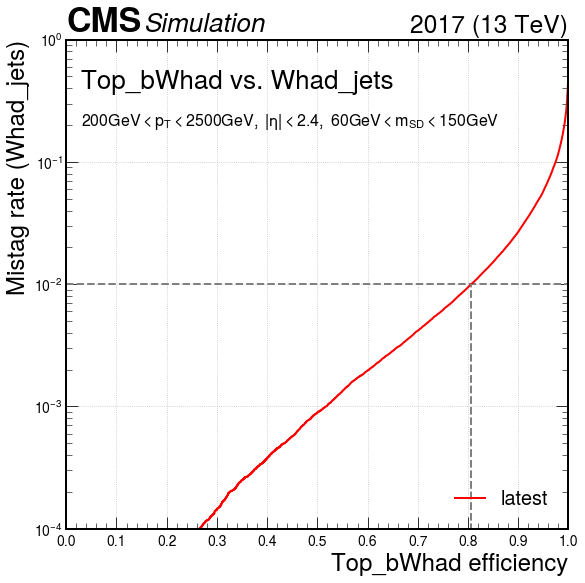

In [124]:
for xlabel in labels['latest']:
    plot_ROC(events=cut_events, x_label=xlabel, y_label='Whad_jets', legend_location='lower right')

## Mass-Decorrelation plots of $\mathrm{m_{SD}(QCD)}$

In [194]:
def plot_mass_sculpting(events, tagger, mistag, true_label, eff_thresholds, bins=22, x_min=30,x_max=250):
    """
    events is a a dictionary, key: tagger, value: events
    """
    ## pre-analysis
    bin_width=(x_max-x_min)/bins
    bincenters=[x_min+bin_width/2+i*bin_width for i in range(bins)]
    colorlist=['blue','green','red']
    
    ## Upper histogram panel
    ## canvas initializing
    f = plt.figure(figsize=(10,10))
    #mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')
    plt.rcParams['axes.prop_cycle'] = cycler(color=colorlist)

    ## Ratio panel
    ## canvas initializing
    ax1 = f.add_subplot(gs[1]); 
    ax1.grid()

    ## plot
    ax1.plot([x_min,x_max], [1,1], 'black')

    ## plot
    e=events[tagger]
    x_y_truth = (e[mistag]==1) | (e[true_label]==1)
    _disc_score = disc_score(e, sig=mistag, bkg=true_label)[x_y_truth]
    fpr, tpr, _threshold = roc_curve(y_true=e[mistag][x_y_truth], y_score=_disc_score, pos_label=1)
    threshold_at_fpr = interpolate.interp1d(fpr, _threshold) 
    
    hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
    hist.fill(e['fj_sdmass'][e[true_label]==1])
    h0, err0 = hist.view().value, np.sqrt(hist.view().variance)
    hep.histplot(h0/sum(h0), bins=hist.axes[0].edges, xerr=bin_width/2, yerr=err0/sum(h0), label='inc. '+true_label, histtype='errorbar',color='black',ax=ax)
    
    for eff_cut, c in zip(eff_thresholds, colorlist):
        score_cut = threshold_at_fpr(eff_cut)
        disc_score_mistag = disc_score(e, sig=mistag, bkg=true_label)*(e[true_label]==1)
        
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(e['fj_sdmass'][disc_score_mistag>score_cut])
        h, err = hist.view().value, np.sqrt(hist.view().variance)
        hep.histplot(h/sum(h), bins=hist.axes[0].edges, xerr=bin_width/2, yerr=err/sum(h), label=r'$\varepsilon_{bkg}=$'+'%.1g'%(eff_cut*100)+'%', histtype='errorbar',ax=ax,color=c)
        hep.histplot(h/h0*sum(h0)/sum(h), bins=hist.axes[0].edges, xerr=bin_width/2, yerr=err/h0*sum(h0)/sum(h), label=r'$\varepsilon_B$'+'%.1g'%(eff_cut*100)+'%', histtype='errorbar',ax=ax1,color=c)
    
        
    ## Signal jet distribution
    hist = bh.Histogram(bh.axis.Regular(bins*4, x_min, x_max), storage=bh.storage.Weight())
    hist.fill(e['fj_sdmass'][e[mistag]==1])
    h, err = hist.view().value, np.sqrt(hist.view().variance)
    hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=mistag, histtype='step', density=True, ax=ax,color='darkorange')
    
    
    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    ax.set_ylabel('A.U.', ha='right', fontsize=20, y=1.0)
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(25)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax1.xaxis.set_major_locator(x_major_locator)
    ax1.set_xlabel(r'$\rm m_{SD}$ [GeV]', ha='right', x=1.0, fontsize=20)
    ax1.set_ylabel(r'$\frac{\varepsilon_B}{inclusive}$', ha='center', fontsize=24)
    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(0.5, 1.5)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    

    ## title, text and legend
    ax.legend(loc=[0.67,0.4], fontsize=20, frameon=False)
    ax.text(245, 0.92*ax.get_ylim()[1], true_label+" mistagged by "+mistag, fontsize=26,color="black", horizontalalignment='right')
    #ax.text(245, 0.85*ax.get_ylim()[1], "Using "+ tagger +' tagger', fontsize=20,color="black", horizontalalignment='right')
    ax.text(245, 0.85*ax.get_ylim()[1],fr"$\rm {pt_min}GeV<p_T<{pt_max}GeV,\ |\eta|<{abs_eta_max}$", fontsize=18,color="black", horizontalalignment='right')
    

    #ax1.plot([xmin,xmax], [0.5,0.5], 'grey:'); ax1.plot([xmin,xmax], [1.5,1.5], 'grey:') # optional line at ratio=0.5, 1.5
    #plt.errorbar(bincenters0, hist0, xerr=[5 for i in range(22)], yerr=errors0, fmt='o', label=r'inclusive', markersize=5, capsize=3, color='grey')
    

    ## finalizing
    tagger=tagger.replace('(', '').replace(')', '').replace('/', '')
    plt.savefig(f'plots/mass_sculpting_{true_label}_{tagger}_{mistag}.pdf',bbox_inches='tight')
    plt.show()

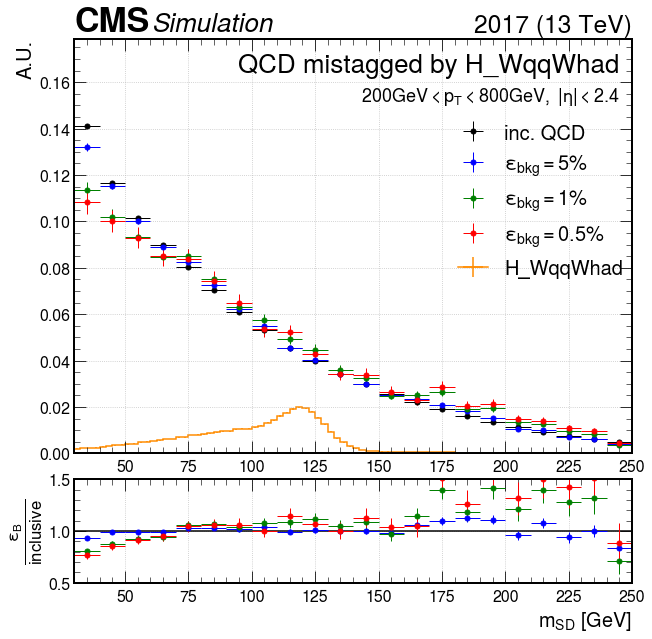

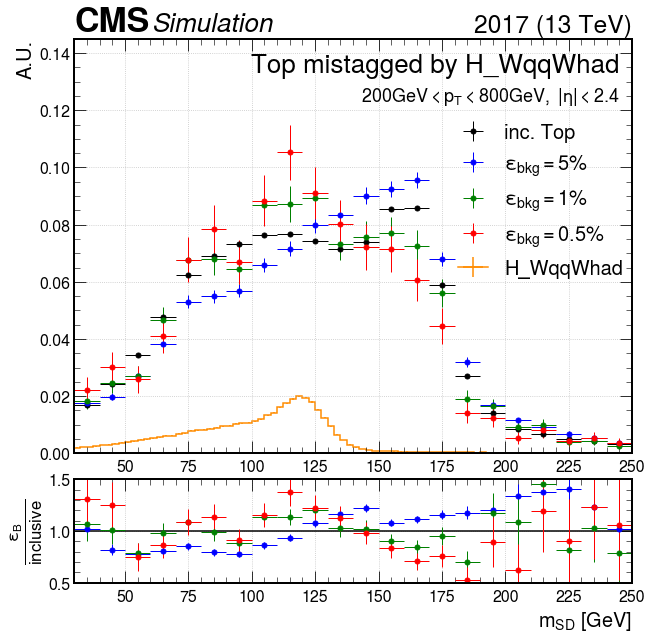

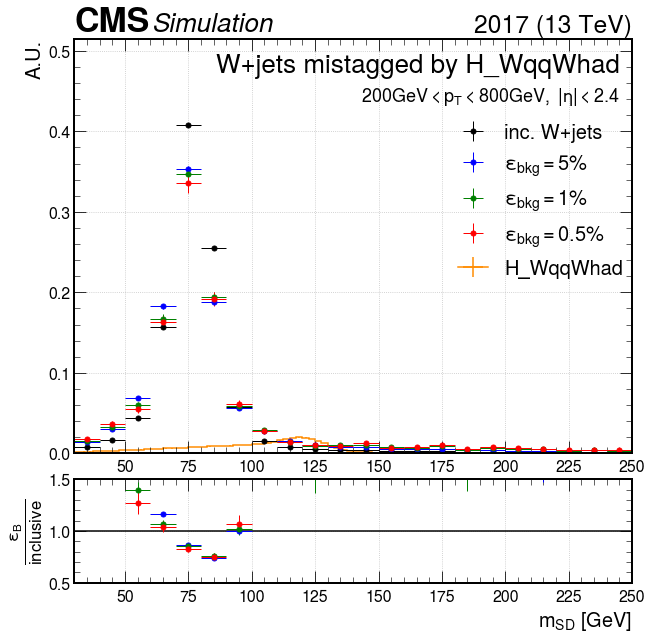

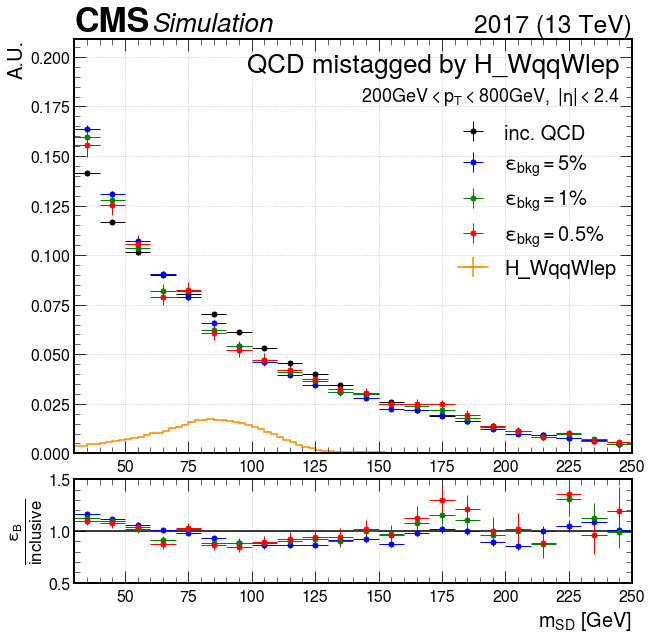

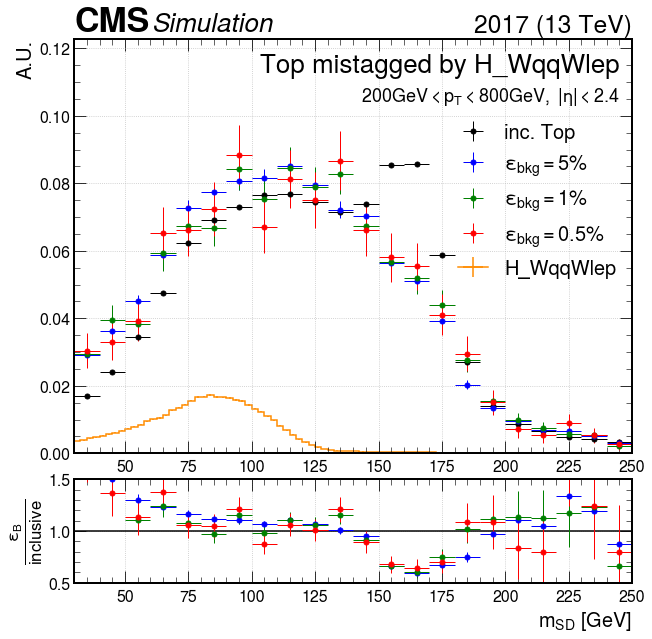

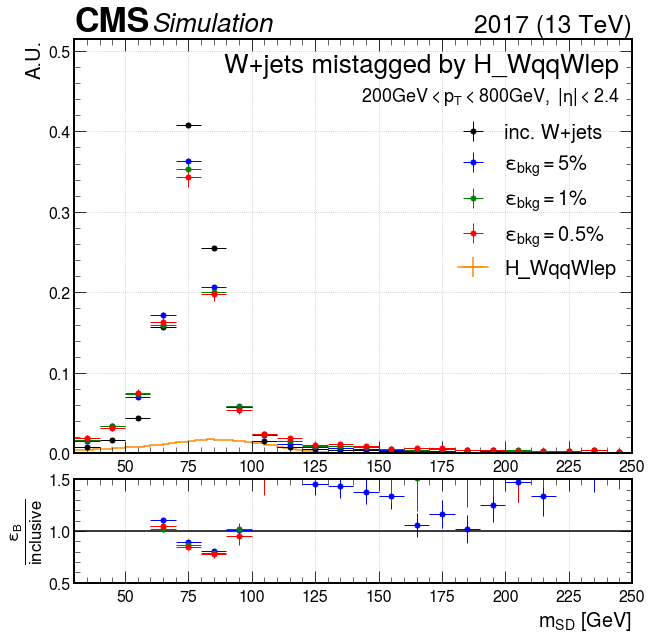

In [195]:
e_B=[0.05, 0.01,0.005]
for xlabel in ['H_WqqWhad', 'H_WqqWlep']:
    for ylabel in ['QCD', 'Top', 'W+jets',]:
        plot_mass_sculpting(events=no_m_cut_events, tagger='latest', mistag=xlabel, true_label=ylabel, eff_thresholds=e_B)

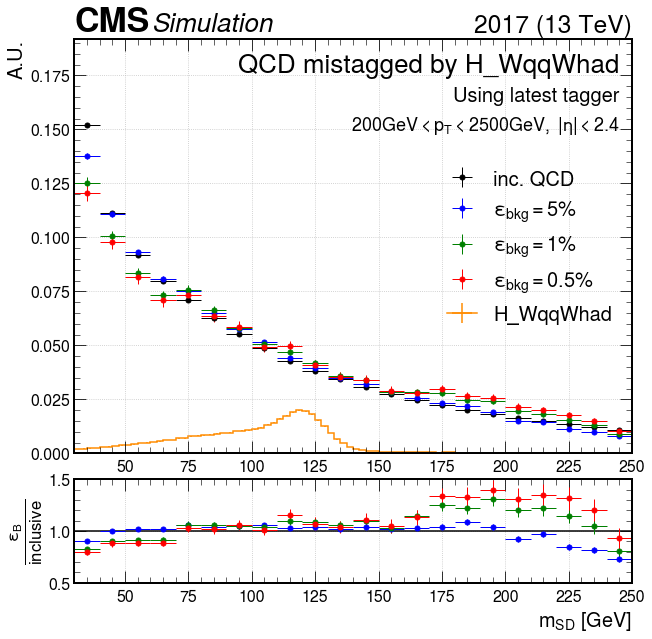

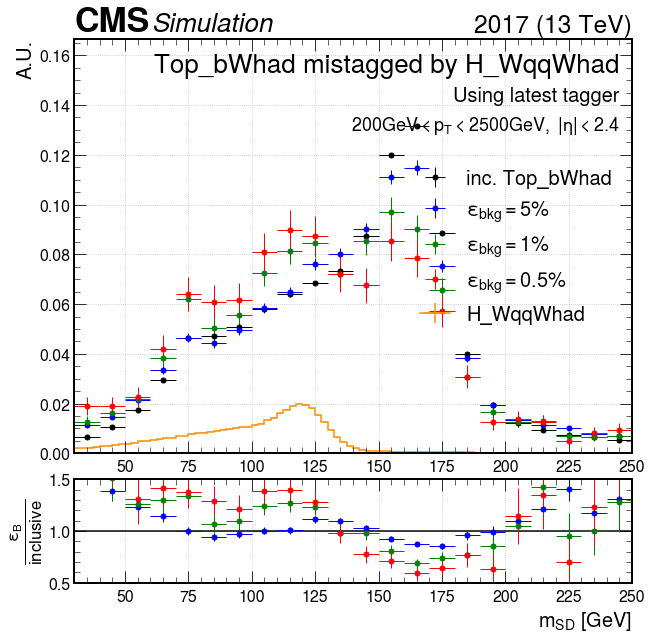

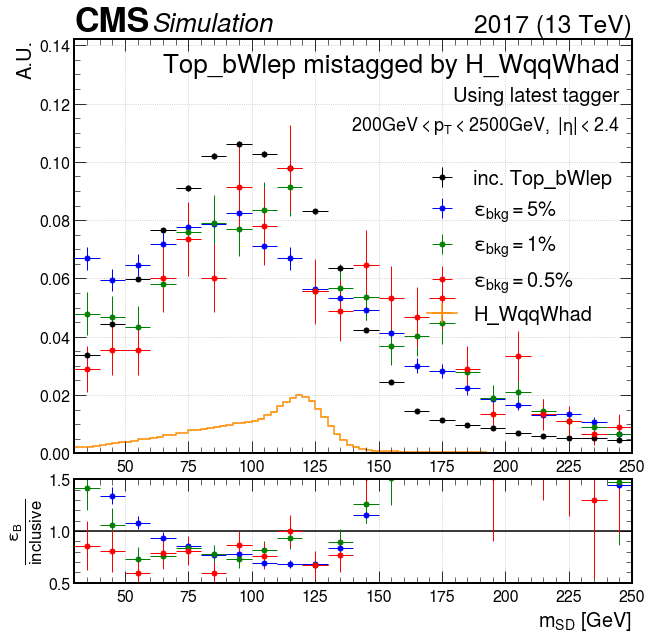

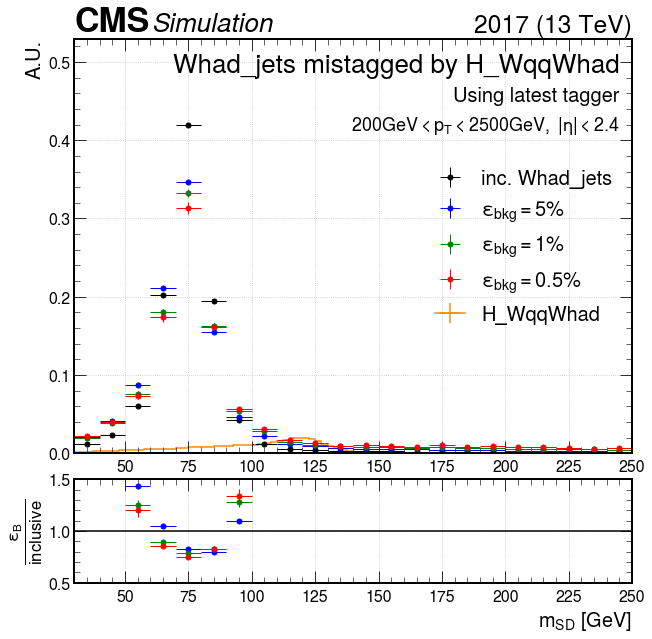

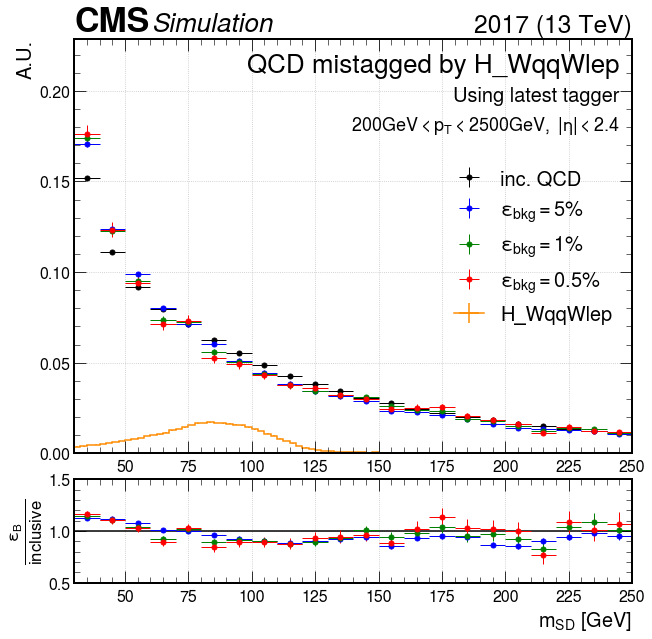

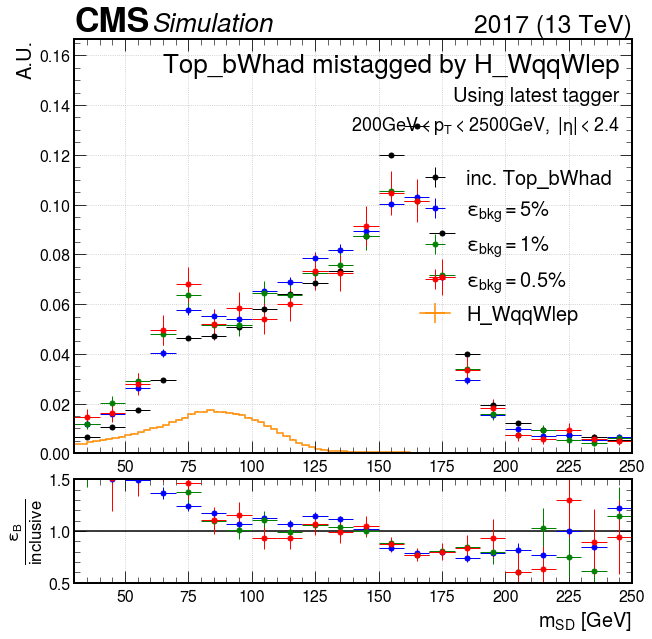

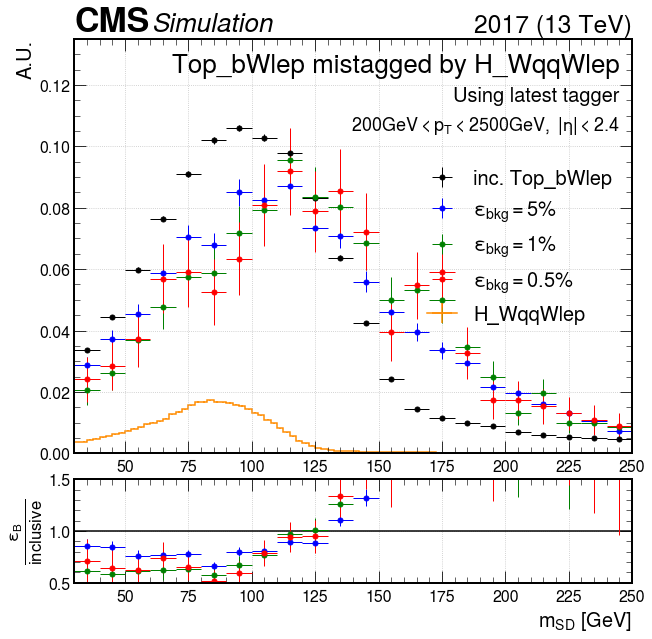

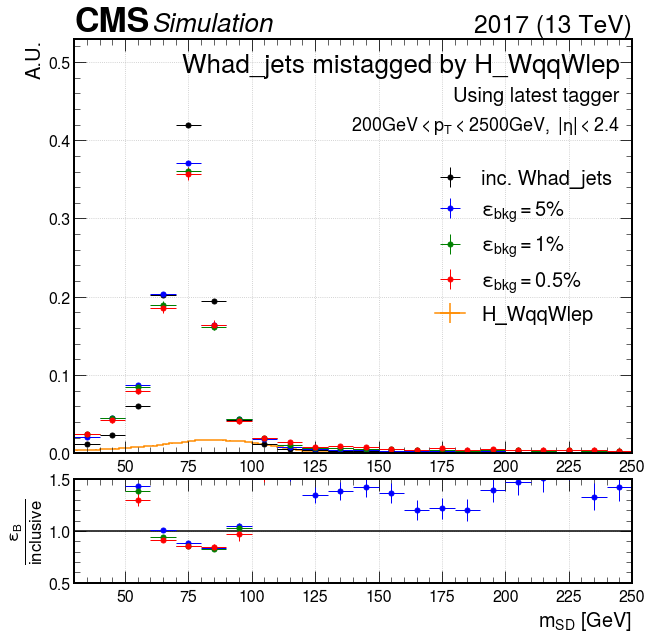

In [130]:
e_B=[0.05, 0.01,0.005]
for xlabel in ['H_WqqWhad', 'H_WqqWlep']:
    for ylabel in ['QCD', 'Top_bWhad', 'Top_bWlep', 'Whad_jets',]:
        plot_mass_sculpting(events=no_m_cut_events, tagger='latest', mistag=xlabel, true_label=ylabel, eff_thresholds=e_B)

___
## ROC curves of multi-modes on the same plot rescaled by $\mathrm{\frac{\#\ (\eta,\ p_T\ \&\ m_{SD})\ cuts}{\#\ (\eta,\ p_T)\ cuts}}$

### plotting ROC curves

In [ ]:
## MDtaggers=['gen','gen-addis','sd','sd-addis'], Already defined at the begining
## channels=['4q','3q','evqq','mvqq','tauevqq','taumvqq','tauhvqq'], Already defined at the begining

def plot_ROC_multimodes(solid, dashed): 
    channels=['4q','3q','evqq','mvqq','tauevqq','taumvqq','tauhvqq']
    ## canvas initializing
    plt.figure(figsize=(9,9))
    plt.grid()
    ax=plt.gca()
    hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')

    ## plot
    if dashed != '':
        #plt.plot(0,0,linestyle='dashed', linewidth=2, label=dashed, color="black")
        for channel in channels:
            tagger = dashed
            plt.plot(tpr[tagger][channel], fpr[tagger][channel]*rescale_QCD[tagger][channel], linestyle="dashed", linewidth=2, label=LaTeX_channels[channel], color=colors[channel])

    if solid != '':
        #plt.plot(0,0,linestyle='solid', linewidth=2, label=solid, color="black")
        for channel in channels:
            tagger = solid
            plt.plot(tpr[tagger][channel]*rescale_WW[tagger][channel], fpr[tagger][channel]*rescale_QCD[tagger][channel], linestyle="solid", linewidth=2, label=LaTeX_channels[channel], color=colors[channel])
    
    
    ## axises
    plt.xlim(0, 1)
    plt.ylim(1e-4,1)
    x_major_locator=plt.MultipleLocator(0.1)
    ax.xaxis.set_major_locator(x_major_locator)
    #y_major_locator=MultipleLocator(1)
    #ax.yaxis.set_major_locator(y_major_locator)
    plt.xlabel(r'$\varepsilon_S$', fontsize=24, ha='right', x=1)
    plt.ylabel(r'$\varepsilon_B$', fontsize=24, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.yscale('log')

    ## texts and legends
    plt.legend(loc=(0.01,0.41), frameon=False, fontsize=16, ncol=1)
    plt.text(0.03, 0.55*ax.get_ylim()[1], fr"$\rm H\to WW\to$ multi-modes vs. QCD multijet", fontsize=26,color="black")
    plt.text(0.03, 0.35*ax.get_ylim()[1], rf"$\rm {pt_min}GeV<p_T<{pt_max}GeV,\ |\eta|<{abs_eta_max}$", fontsize=18,color="black")
    plt.text(0.03, 0.2*ax.get_ylim()[1], rf"$\rm{mass_min}GeV<m_{{SD}}<{mass_max}GeV$", fontsize=18,color="black")
    
    plt.text(0.97, 2e-4, "rescaled by:\n"+r"$\mathrm{\frac{(\eta,\ p_T\ &\ m_{SD})\ cuts}{(\eta,\ p_T)\ cuts}}$", fontsize=24, color="black",ha='right')
    # plt.text(0.1, 0.9e-1,r"$\rm 90GeV<m_{SD}<140GeV$", fontsize=16,color="black")
    # plt.text(0.1, 0.2e-1,"AUC(MD)=%.4f"%(roc_auc_new), fontsize=20,color="red")
    # plt.text(0.5, 0.2e-3,"AUC(non-MD)=%.4f"%(roc_auc_old), fontsize=20,color='blue')

    ## finalizing
    plt.savefig(f"plots/ROC_HWW_{dashed}&{solid}_multi-modes.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
#plot_ROC_multimodes(solid='gen-addis', dashed='gen-addis-onlymu')
#plot_ROC_multimodes(solid='gen-addis', dashed='gen')
#plot_ROC_multimodes(solid='gen-addis-onlymu', dashed='gen')
#plot_ROC_multimodes(solid='PKU_std', dashed='')
#plot_ROC_multimodes(solid='sd-addis', dashed='sd')
#plot_ROC_multimodes(solid='sd-addis-onlymu', dashed='sd')